In [1]:
from sklearn.tree import DecisionTreeRegressor

from sklearn import model_selection
import numpy as np
from sklearn.datasets import load_diabetes
import matplotlib.pyplot as plt
import pandas as pd

Задание 1: Для реализованной в методичке модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.

Задание 2: Модифицировать реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. Сравнить на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.

Задание 3: Реализовать алгоритм градиетного бустинга, основанный на реализации решающего дерева из ДЗ4 / методички к уроку 4. Сделать выводы о качестве алгоритма по сравнению с реализацией из п.1.

## task 01

In [2]:
def gb_predict(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
    return np.array([sum([eta* coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])

In [3]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

In [4]:
def bias(y, z):
    return 2 * (y - z)

In [5]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta, model):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
#         tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
        tree = model(max_depth=max_depth, min_samples_leaf=5, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, bias(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [6]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta):
    train_prediction = gb_predict(X_train, trees, coefs, eta)
    train_err = mean_squared_error(y_train, train_prediction)

#     print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
#     с шагом {eta} на тренировочной выборке: {train_err}')

    test_prediction = gb_predict(X_test, trees, coefs, eta)
    test_err = mean_squared_error(y_test, test_prediction)

#     print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
#     с шагом {eta} на тестовой выборке: {test_err}')
    return train_err, test_err

In [7]:
def err_plot(n_trees, max_depth, eta, train_err, test_err, axes_counter):
            axi = ax.flatten()[axes_counter]
            axi.set_xlabel('Iteration number')
            axi.set_ylabel('MSE')
            axi.set_xlim(0, n_trees)
            axi.plot(list(range(n_trees)), train_err, label='train error')
            axi.plot(list(range(n_trees)), test_err, label='test error')
            axi.legend(loc='upper right')
            axi.set_title(f'{axes_counter}. Trees: {n_trees}, depth: {max_depth}, eta: {eta}')

In [8]:
X, y = load_diabetes(return_X_y=True)

In [9]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

In [10]:
params = {
    'n_trees': [3, 6, 10, 30],
    'max_depth': [2, 5, 8, 10],
    'eta': [1, 0.1, 0.01]
}

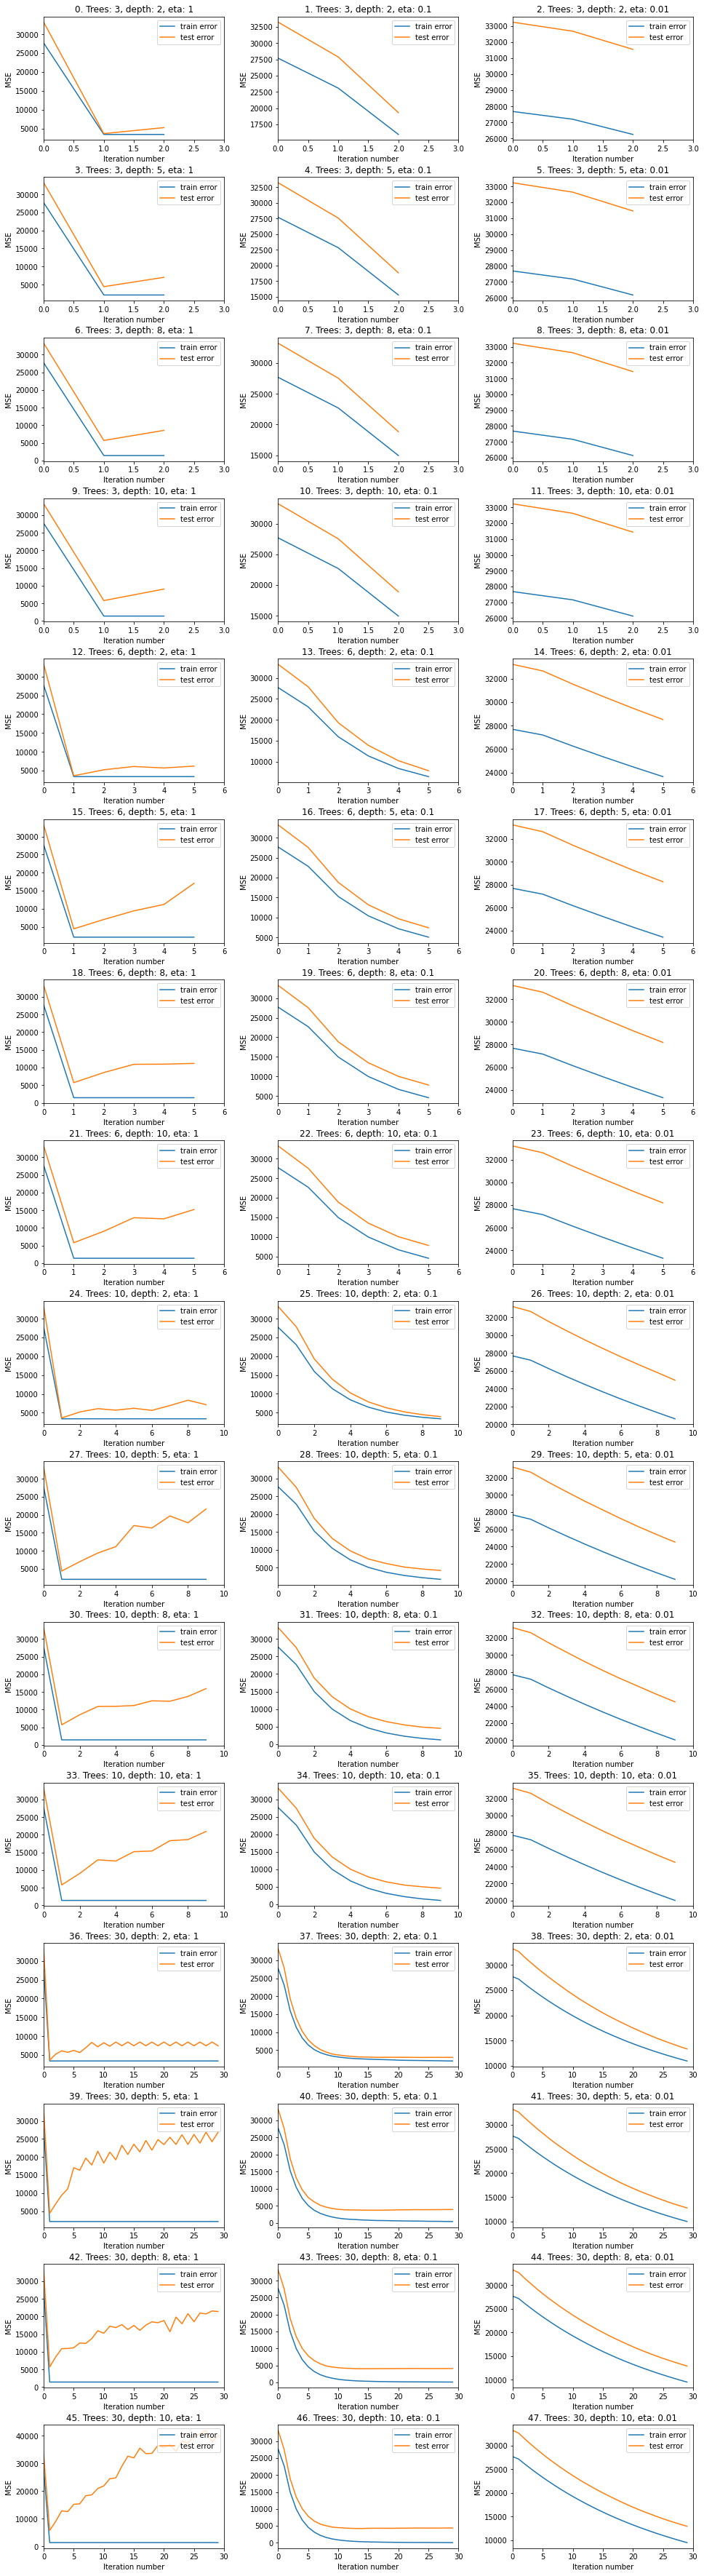

In [11]:
rows = (np.prod([len(params[i]) for i in params]) + 2) // 3

fig, ax = plt.subplots(nrows = rows, ncols = 3)
fig.set_size_inches(16, 4 * rows)
fig.subplots_adjust(wspace=0.3, hspace=0.3)

errors = []
axes_counter = 0
for n_trees in params['n_trees']:
    for max_depth in params['max_depth']:
        for eta in params['eta']:
            coefs = [1] * n_trees
            trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta, DecisionTreeRegressor)
            train_err, test_err = evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)
            errors.append([n_trees, max_depth, eta, train_err, test_err])
            err_plot(n_trees, max_depth, eta, train_errors, test_errors, axes_counter)
            axes_counter +=1

            

In [12]:
df = pd.DataFrame(errors, columns = ['n_trees', 'max_depth', 'eta', 'train_err', 'test_err'])
df

,n_trees,max_depth,eta,train_err,test_err
0,3,2,1.00,3406.919769,6095.507965
1,3,2,0.10,11373.241012,13899.079245
2,3,2,0.01,25348.897146,30495.087198
3,3,5,1.00,2114.260089,9412.042274
4,3,5,0.10,10416.293530,13181.122183
5,3,5,0.01,25217.795663,30354.265774
6,3,8,1.00,1447.692635,10903.183373
7,3,8,0.10,9985.334761,13488.841424
8,3,8,0.01,25157.097269,30323.210285
9,3,10,1.00,1384.834031,12882.315520


In [13]:
df.loc[df['test_err'] == df['test_err'].min()]

,n_trees,max_depth,eta,train_err,test_err
37,30,2,0.1,1945.535201,2992.279457


При зафиксированном eta увеличение глубины деревьев ведет к переобучению, увеличение количества деревьев также приводит к переобучению, но с меньшим размером ошибки
При уменьшении eta алгоритм начинает сходиться на большем количестве деревьев
Оптимальный результат на данной выборке при текущем наборе параметров мы получили на 30 деревьях глубиной 2 с eta = 0.10

## task 03

In [14]:
%%capture
%run les04_cls.ipynb

In [15]:
n_trees = 10
max_depth = 5
eta = 0.10
coefs = [1] * n_trees

In [16]:
trees_alg, train_errors_alg, test_errors_alg = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta, DecisionTreeRegressor_alg)

In [17]:
trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta, DecisionTreeRegressor)

In [18]:
train_err_alg, test_err_alg = evaluate_alg(X_train, X_test, y_train, y_test, trees_alg, coefs, eta)
train_err_alg, test_err_alg

(1382.519689929157, 3989.5589823886066)

In [19]:
train_err, test_err = evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)
train_err, test_err

(1382.519689929157, 3966.519561041493)

Результаты на двух реализациях алгоритмов получили одинаковые

## task 02

In [20]:
def sgb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta, model):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
#     n = int(X_train.shape[0] * 0.5)
    
#     X_ = pd.DataFrame(X_train)
#     X_['y'] = y_train
#     X_ = X_.sample(frac = 1)
   
#     X_train_tmp = np.array(X_.iloc[:, :X_.shape[1] -1][0 : n+1])
#     y_train_tmp = np.array(X_.iloc[:, -1][0: n+1])
  
    for i in range(n_trees):
#             tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
        tree = model(max_depth=max_depth, min_samples_leaf=5, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            idx = np.random.choice(range(0, len(X_train)), size = len(X_train)//2, replace = False)
            X_train_tmp, y_train_tmp = X_train[idx], y_train[idx]
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train_tmp, y_train_tmp)

            train_errors.append(mean_squared_error(y_train_tmp, gb_predict(X_train_tmp, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train_tmp, trees, coefs, eta)

            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train_tmp, bias(y_train_tmp, target))

            train_errors.append(mean_squared_error(y_train_tmp, gb_predict(X_train_tmp, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

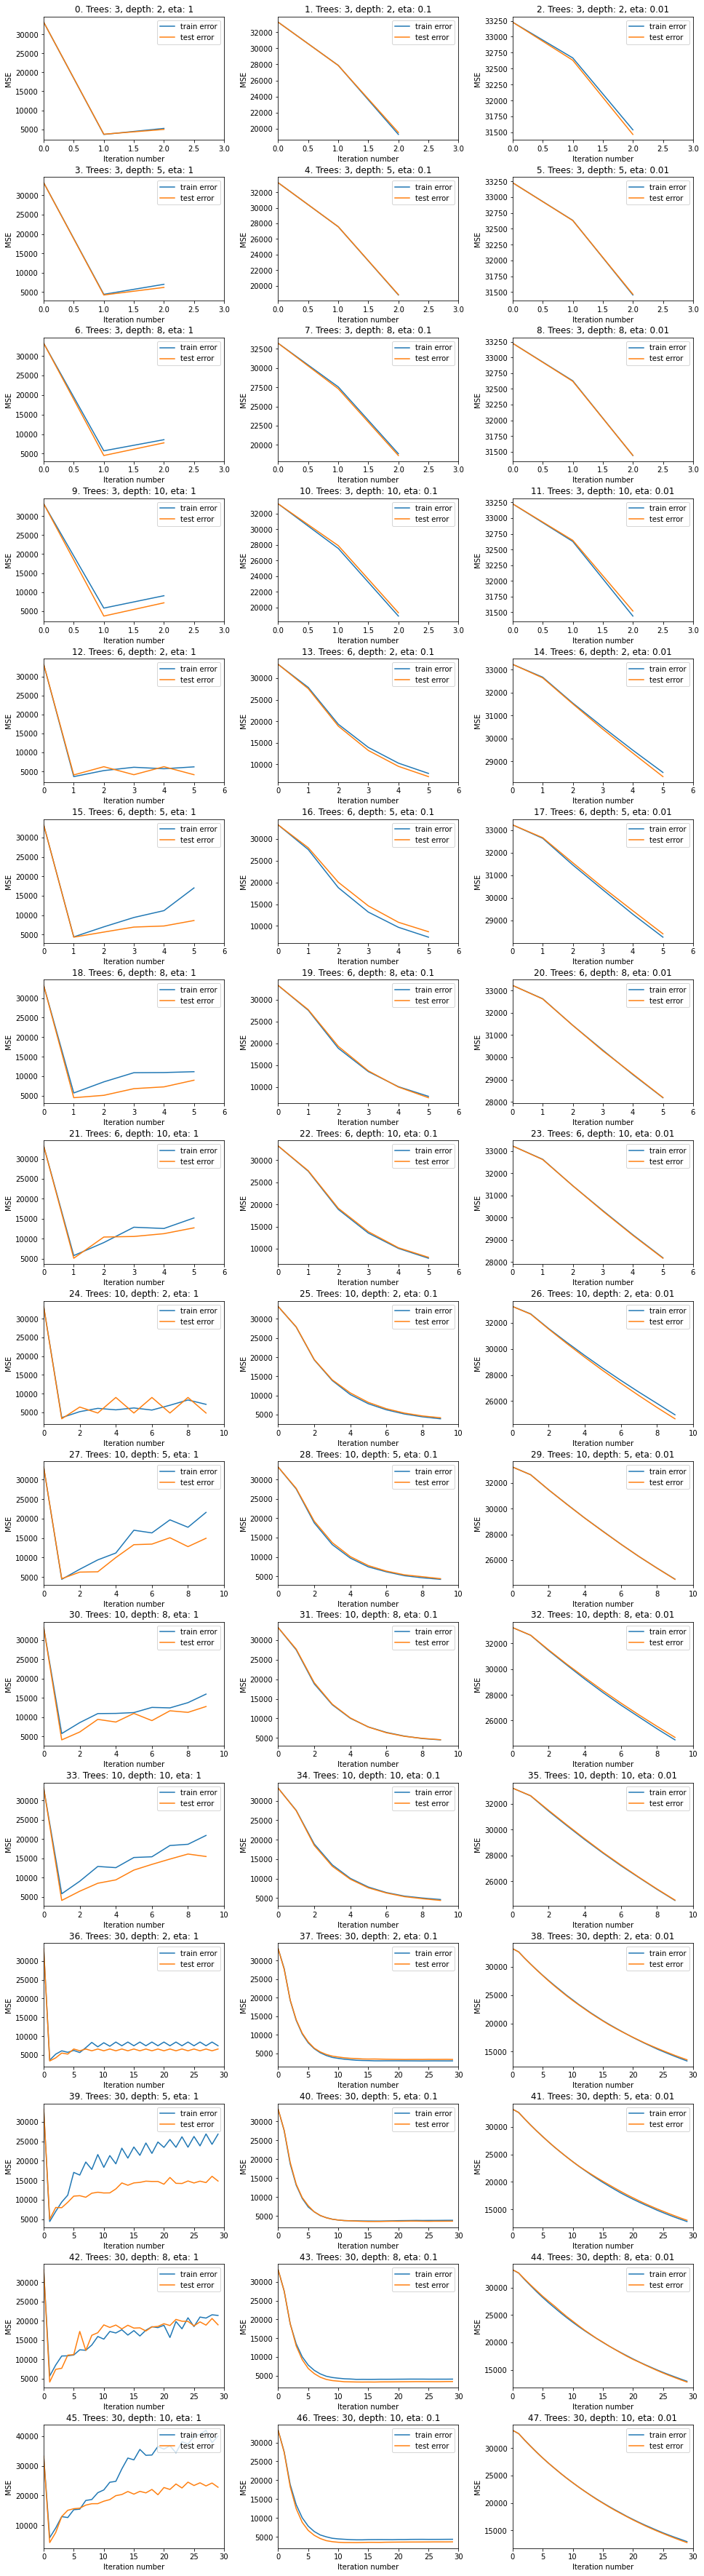

In [21]:
rows = (np.prod([len(params[i]) for i in params]) + 2) // 3

fig, ax = plt.subplots(nrows = rows, ncols = 3)
fig.set_size_inches(16, 4 * rows)
fig.subplots_adjust(wspace=0.3, hspace=0.3)

errors = []
axes_counter = 0
for n_trees in params['n_trees']:
    for max_depth in params['max_depth']:
        for eta in params['eta']:
            coefs = [1] * n_trees
            trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta, DecisionTreeRegressor)
            trees_sgb, train_errors_sgb, test_errors_sgb = sgb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta, DecisionTreeRegressor)
            train_err, test_err = evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)
            train_err_sgb, test_err_sgb = evaluate_alg(X_train, X_test, y_train, y_test, trees_sgb, coefs, eta)
            errors.append([n_trees, max_depth, eta, test_err, test_err_sgb])
            err_plot(n_trees, max_depth, eta, test_errors, test_errors_sgb, axes_counter)
            axes_counter +=1

При eta = 1 с увеличением количества деревьев ошибки на тесте у стохастического градиентного бустинга начинают сильно расходиться с градиентным. На малых eta ошибки остаются довольно близкими